# Задание для кандидатов на позицию DS

### Исходные данные

К заданию прилагается два файла:

- training_dataset.txt – содержит выборку названий товаров и услуг, которая была размечена вручную и включает следующие классы:

 -   НЕ Сигареты ROTHMANS
 -   Сигареты ROTHMANS (неизвестно или нет в списке)
 -   Сигареты ROTHMANS DEMI
 -   Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)
 -   Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)
 -   Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)
 -   Сигареты ROTHMANS DEMI SILVER (серый)
 -   Сигареты ROYALS BY ROTHMANS


- test_dataset.txt – тестовая выборка случайных названий товаров и услуг, которую необходимо разметить автоматически по указанным выше классам.

In [1]:
# Библиотеки

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

%matplotlib inline

In [2]:
os.listdir('./ofd-data/')

['dataPrep',
 'models',
 '.ipynb_checkpoints',
 'test_dataset.txt',
 'training_dataset.txt',
 'predicted.txt']

In [3]:
train_data = pd.read_csv('./ofd-data/training_dataset.txt', sep='\t')
train_data.head()

,name,result
0,1.вода аква минерале газ 0.,НЕ Сигареты ROTHMANS
1,"сигареты""keht""",НЕ Сигареты ROTHMANS
2,сигареты стиль rose ssl jade (жадэ розовый),НЕ Сигареты ROTHMANS
3,мин вода нарзан 0.5л пэт,НЕ Сигареты ROTHMANS
4,пирожок печен с мясом,НЕ Сигареты ROTHMANS


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 2 columns):
name      9998 non-null object
result    9998 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


/home/daria/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


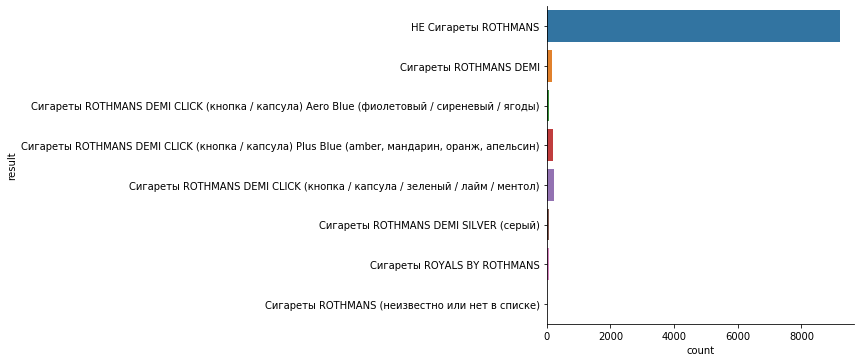

In [5]:
# Посмотрим на количество примеров по категориям:

sns.catplot(y='result', kind='count', data=train_data)
plt.show()

In [6]:
train_data['result'].value_counts()

НЕ Сигареты ROTHMANS                                                                            9200
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)                        222
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)     185
Сигареты ROTHMANS DEMI                                                                           172
Сигареты ROTHMANS DEMI SILVER (серый)                                                             76
Сигареты ROYALS BY ROTHMANS                                                                       75
Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)        59
Сигареты ROTHMANS (неизвестно или нет в списке)                                                    9
Name: result, dtype: int64

In [7]:
# Хорошо бы этот класс совсем убрать или доразметить

train_data[train_data['result'] == 'Сигареты ROTHMANS (неизвестно или нет в списке)']

,name,result
1979,ротманс деми блю бат,Сигареты ROTHMANS (неизвестно или нет в списке)
2720,сигареты ротманс роял деми блу,Сигареты ROTHMANS (неизвестно или нет в списке)
3398,rothmans demi слим blue 100,Сигареты ROTHMANS (неизвестно или нет в списке)
6392,"сиг""rothmans demi click"" блю",Сигареты ROTHMANS (неизвестно или нет в списке)
7671,ротманс роялс деми блю 90 руб,Сигареты ROTHMANS (неизвестно или нет в списке)
7786,сигареты ротманс деми блю 100,Сигареты ROTHMANS (неизвестно или нет в списке)
7799,сигареты ротманс деми блю,Сигареты ROTHMANS (неизвестно или нет в списке)
8858,ротманс деми блю сигареты 1/10 мрц100,Сигареты ROTHMANS (неизвестно или нет в списке)
9531,ротманс ss blue тонкие деми,Сигареты ROTHMANS (неизвестно или нет в списке)


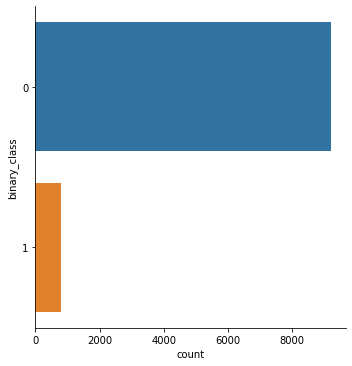

In [8]:
# Разделим выборку на сигареты и не сигареты:

train_data['binary_class'] = train_data['result'].apply(lambda x: 0 if x == 'НЕ Сигареты ROTHMANS' else 1)
sns.catplot(y='binary_class', kind='count', data=train_data)
plt.show()

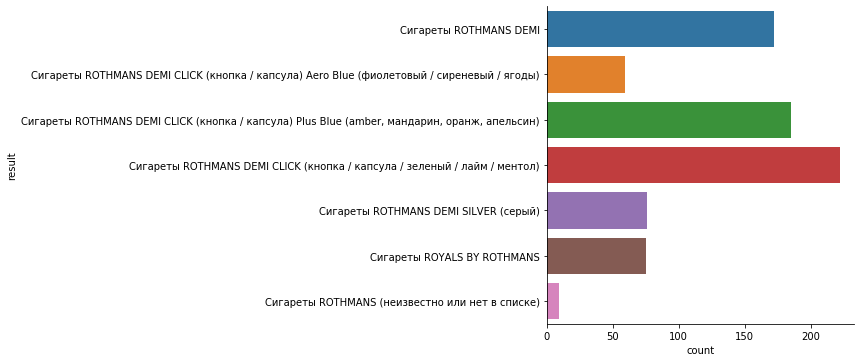

In [9]:
# Сигареты отдельно:

sns.catplot(y='result', kind='count', data=train_data[train_data['binary_class'] == 1])
plt.show()

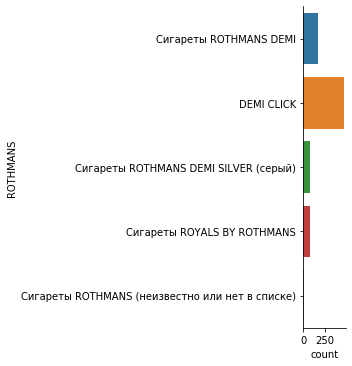

In [10]:
def rotcats(cat):
    if cat in ['Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)',
       'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)',
       'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)',
              ]:
        return 'DEMI CLICK'
    else:
        return cat

train_data['ROTHMANS'] = train_data['result'].apply(lambda x: rotcats(x))

sns.catplot(y='ROTHMANS', kind='count', data=train_data[train_data['binary_class'] == 1])
plt.show()

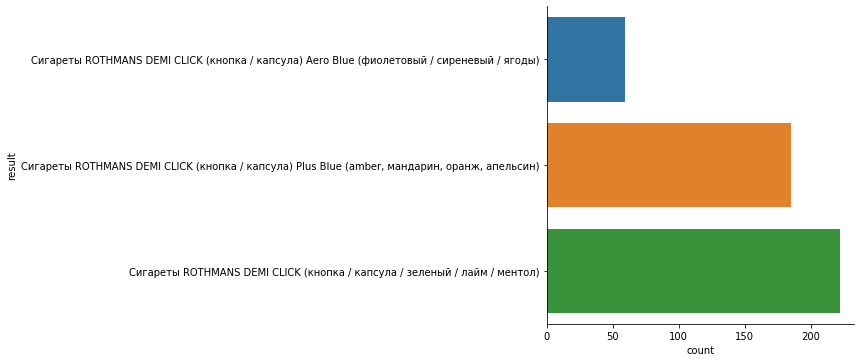

In [11]:
sns.catplot(y='result', kind='count', data=train_data[(train_data['binary_class'] == 1) & 
                                                  (train_data['ROTHMANS'] == 'DEMI CLICK')])
plt.show()

In [12]:
# Предобработка текста, выделение слов, удаление знаков пунктуации

special_char_list = [':', ';', '?', '}', ')', '{', '(', '.', '/', '\/', ',', '"',
                    '-', '*']
train_data['name'] = train_data['name'].apply(lambda x: x.lower())
for special_char in special_char_list:
    train_data['name'] = train_data['name'].apply(lambda x: x.replace(special_char, ''))

train_data['name'] = train_data['name'].apply(lambda x: ' '.join(re.findall('.....', x)))

In [13]:
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train_data.name)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

joblib.dump(count_vect, './ofd-data/dataPrep/count_vect.sav')
joblib.dump(tfidf_transformer, './ofd-data/dataPrep/tfidf_transformer.sav')

X_train_counts.shape, X_train_tfidf.shape

((9998, 22960), (9998, 22960))

In [14]:
# Будем последовательно отделять классы:

# Сигареты - Не сигареты (1 классификатор)
# Сигареты по категориям: нет в списке, роял, деми, деми клик, деми силвер (2 классификатор)
# Сигареты деми клик по внутренним категориям (3 классификатор)

In [15]:
clf_1 = MultinomialNB()
param = {'alpha': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
grid_1 = GridSearchCV(clf_1, param, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=7, shuffle = True,
                                                                                    random_state=123),
                   return_train_score=True, verbose=True)
grid_1.fit(X_train_tfidf, train_data.binary_class)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=True)

In [16]:
best_c = grid_1.best_params_
best_score = grid_1.best_score_
joblib.dump(grid_1.best_estimator_, './ofd-data/models/first_model.sav')
print(best_c)
print('ROC AUC score: ',best_score)

{'alpha': 0.1}
ROC AUC score:  0.9999056084158677


In [17]:
# Следующий алгоритм учим только на категориях сигарет Ротманс:

X_train_selected_1 = X_train_tfidf[train_data[train_data['binary_class'] == 1].index]

le_1 = LabelEncoder()
reslabels_1 = le_1.fit_transform(train_data[train_data['binary_class'] == 1].ROTHMANS)
joblib.dump(le_1, './ofd-data/labelEncoder1.sav')

['./ofd-data/labelEncoder1.sav']

In [18]:
clf_2 = MultinomialNB()
param = {'alpha': [0,1e-5, 1e-6, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
grid_2 = GridSearchCV(clf_2, param, n_jobs=-1, cv=StratifiedKFold(n_splits=3, shuffle = True,
                                                                 random_state=123),
                      scoring='f1_weighted',
                   return_train_score=True, verbose=True)
grid_2.fit(X_train_selected_1, reslabels_1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 1e-05, 1e-06, 1e-07, 0.0001, 0.001, 0.01,
                                   0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_weighted', verbose=True)

In [19]:
best_c = grid_2.best_params_
best_score = grid_2.best_score_
joblib.dump(grid_2.best_estimator_, './ofd-data/models/second_model.sav')
print(best_c)
print('Score f1, weighted: ',best_score)

{'alpha': 1e-05}
Score f1, weighted:  0.7328879087508197


In [20]:
# Отбираем категорию деми клик

le_2 = LabelEncoder()
reslabels_2 = le_2.fit_transform(train_data[(train_data['binary_class'] == 1) & 
                                  (train_data['ROTHMANS'] == 'DEMI CLICK')].result)
joblib.dump(le_2, './ofd-data/labelEncoder2.sav')
X_train_selected_2 = X_train_tfidf[train_data[(train_data['binary_class'] == 1) &
                                        (train_data['ROTHMANS'] == 'DEMI CLICK')].index]

In [21]:
clf_3 = MultinomialNB()
param = {'alpha': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
grid_3 = GridSearchCV(clf_3, param, n_jobs=-1, cv=StratifiedKFold(n_splits=7, shuffle = True,
                                                                 random_state=123),
                      scoring='f1_weighted',
                   return_train_score=True, verbose=True)
grid_3.fit(X_train_selected_2, reslabels_2)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_weighted', verbose=True)

In [22]:
best_c = grid_3.best_params_
best_score = grid_3.best_score_
joblib.dump(grid_3.best_estimator_, './ofd-data/models/third_model.sav')
print(best_c)
print('Score f1, weighted: ',best_score)

{'alpha': 0.01}
Score f1, weighted:  0.8673180073032446


In [23]:
def predictions(X_train_tfidf):
    predictionss = []
    predicts = grid_1.best_estimator_.predict(X_train_tfidf)
    for i, pr in enumerate(predicts):
        if pr == 1:
            pred = le_1.inverse_transform(grid_2.best_estimator_.predict(X_train_tfidf[i]))[0]
            if pred == 'DEMI CLICK':
                pred = grid_3.best_estimator_.predict(X_train_tfidf[i])
                predictionss.append(*le_2.inverse_transform(pred))
            else:
                predictionss.append(pred)
        else:
            predictionss.append('НЕ Сигареты ROTHMANS')
    return predictionss

In [24]:
train_data['predict'] = predictions(X_train_tfidf)

In [25]:
pd.DataFrame.from_dict(classification_report(train_data['result'], 
                                             train_data['predict'],
                                            output_dict=True))

,НЕ Сигареты ROTHMANS,Сигареты ROTHMANS (неизвестно или нет в списке),Сигареты ROTHMANS DEMI,Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол),Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды),"Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)",Сигареты ROTHMANS DEMI SILVER (серый),Сигареты ROYALS BY ROTHMANS,accuracy,macro avg,weighted avg
f1-score,0.999946,0.615385,0.825503,0.890688,0.938053,0.955145,1.0,0.945946,0.992799,0.896333,0.992574
precision,1.000000,1.000000,0.976190,0.808824,0.981481,0.932990,1.0,0.958904,0.992799,0.957299,0.993688
recall,0.999891,0.444444,0.715116,0.990991,0.898305,0.978378,1.0,0.933333,0.992799,0.870057,0.992799
support,9200.000000,9.000000,172.000000,222.000000,59.000000,185.000000,76.0,75.000000,0.992799,9998.000000,9998.000000


In [26]:
test_data = pd.read_csv('./ofd-data/test_dataset.txt', sep='\t', encoding = "cp1251",
                  engine='python')
test_data.head()

,name
0,2000000964829 трихопол таб 250 мг n2
1,сигареты парламент карат синий //
2,перец горький 1 шт
3,"сыр коса ""сочинский"" 120 гр (40)"
4,мертенил таб 5мг №30


In [27]:
test_data['name_new'] = test_data['name'].apply(lambda x: x.lower())
for special_char in special_char_list:
    test_data['name_new'] = test_data['name_new'].apply(lambda x: x.replace(special_char, ''))
    
test_data['name_new'] = test_data['name_new'].apply(lambda x: ' '.join(re.findall('.....', x)))

In [28]:
X_test_counts = count_vect.transform(test_data.name_new)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

test_data['predict'] = predictions(X_test_tfidf)
test_data.drop('name_new', axis=1, inplace=True)

In [29]:
test_data[test_data['predict'] == 'Сигареты ROTHMANS DEMI'].head()

,name,predict
30,"п rothmans demi blue(п., 100,00)",Сигареты ROTHMANS DEMI
221,ротманс деми тонкие,Сигареты ROTHMANS DEMI
446,"сигареты ""rothmans demi 100""",Сигареты ROTHMANS DEMI
671,сиг. rothmans demi мрц100,Сигареты ROTHMANS DEMI
813,сигареты rothmans demi 20 шт (100),Сигареты ROTHMANS DEMI
